In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo
import matplotlib.animation as animation
from matplotlib.colors import LightSource
from matplotlib import cm
import matplotlib.colors

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [28]:
# Open BedMachine data
BM_v3_data = xr.open_dataset('/Users/5941962/Downloads/melt-master/BedMachineAntarctica-v3.nc')

# Print coordinates and available variables
print(BM_v3_data.var)

<bound method DatasetAggregations.var of <xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    dataid     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:         

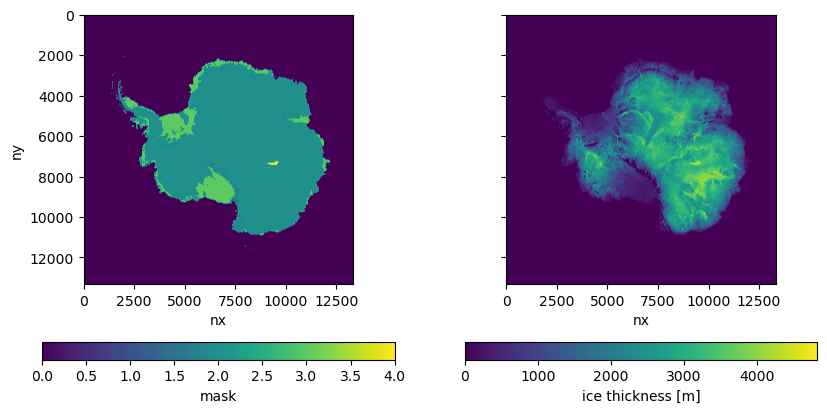

In [29]:
fig,ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

# Plot mask
im = ax[0].imshow(BM_v3_data.mask)
plt.colorbar(im , ax = ax[0], orientation='horizontal', label='mask')

# Plot thickness
im = ax[1].imshow(BM_v3_data.thickness)
plt.colorbar(im, ax = ax[1], orientation='horizontal', label='ice thickness [m]')

for axs in ax:
    axs.set_aspect(1)
    axs.set_xlabel('nx')
ax[0].set_ylabel('ny');

In [32]:
# Create cut-out of one ice shelf

# Select ice shelf
shelfname = 'CD' 

# Coordinates for Crosson-Dotson and Pine Island (determine coordinates for yourself using the full Bedmachine data)
if shelfname == 'CD':
    x0,x1,y0,y1 = 3445,3740,7730,8070   # Crosson-Dotson
elif shelfname == 'PI':
    x0,x1,y0,y1 = 3280,3560,7150,7400   # Pine Island

# Read in BedMachine data, choose version
BM = BM_v3_data                         # v3

# Cut out shelf region
shelf = BM.isel(x=slice(x0,x1),y=slice(y0,y1))

shelf.mask[:] = xr.where(shelf.mask==1,2,shelf.mask)                    # adjust mask, mark bare ground as grounded ice (but thickness is zero there)
shelf['draft'] = (shelf.surface-shelf.thickness).astype('float64')      # add draft
shelf = shelf.assign_coords(t=0)                                        # add time stamp

shelf.to_netcdf(f'../data/{shelfname}_bm3.nc')

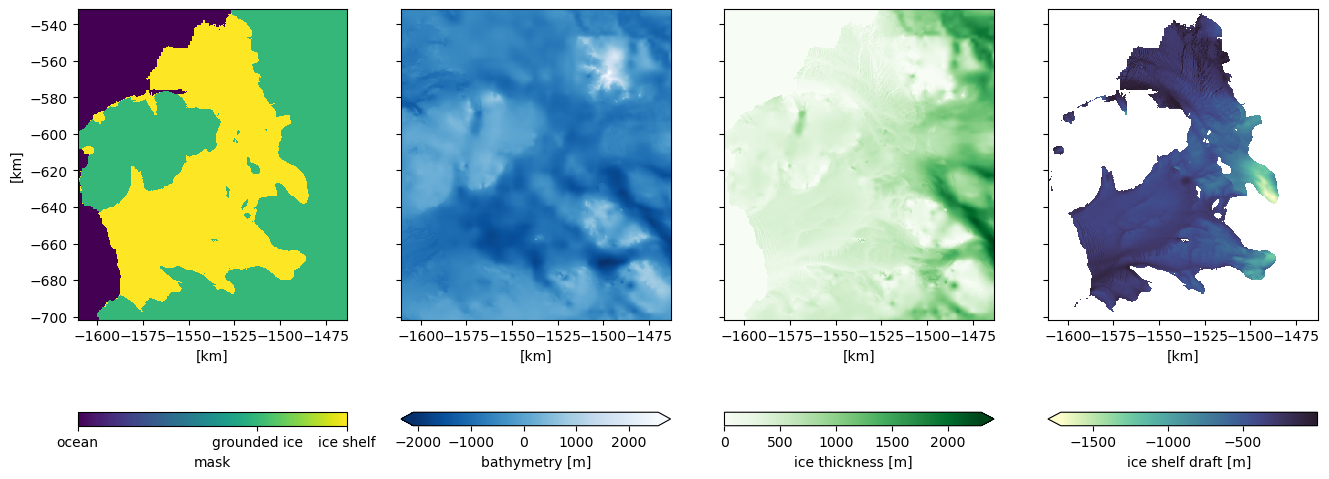

In [33]:
# Plot mask, bathymetry and thickness for cut-out
cutout = xr.open_dataset(f'../data/CD_bm3.nc')

fig,ax = plt.subplots(1,4, figsize=(16,8), sharex=True, sharey=True)

# Plot mask
im = ax[0].pcolormesh(cutout.x/1000, cutout.y/1000, cutout.mask)
cbar = plt.colorbar(im, ax = ax[0], ticks=[0,2,3],label='mask', orientation='horizontal')
cbar.set_ticklabels(['ocean', 'grounded ice', 'ice shelf'])

# Plot bathymetry
im = ax[1].pcolormesh(cutout.x/1000, cutout.y/1000, cutout.bed, cmap='Blues_r')
plt.colorbar(im, ax = ax[1], label='bathymetry [m]', orientation='horizontal', extend='both')

# Plot thickness
im = ax[2].pcolormesh(cutout.x/1000, cutout.y/1000, cutout.thickness, cmap='Greens')
plt.colorbar(im, ax = ax[2], label='ice thickness [m]', orientation='horizontal', extend='max')

# Plot thickness
draft = xr.where(cutout.mask==3, cutout.surface-cutout.thickness, np.nan) # compute only over ice shelf area, draft = how deep ice shelf reaches into the water column
im = ax[3].pcolormesh(cutout.x/1000, cutout.y/1000, draft, cmap='cmo.deep')
plt.colorbar(im, ax = ax[3], label='ice shelf draft [m]', orientation='horizontal', extend='min')

for axs in ax:
    axs.set_aspect(1)
    axs.set_xlabel('[km]')
ax[0].set_ylabel('[km]');